In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import xarray as xr
import numpy as np
ds_dmsp = xr.open_dataset('/content/drive/MyDrive/ndui/dmsp_2012_austin.nc').constant
ds_viirs = xr.open_dataset('/content/drive/MyDrive/ndui/viirs_2012_austin.nc').avg_rad

In [4]:
x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)

In [5]:
import numpy as np

def unpatchify(patches, img_shape):
    patch_size = patches.shape[1]
    assert patches.shape[0] == (img_shape[0] // patch_size) * (img_shape[1] // patch_size), "Patches and image shape are not compatible"

    img = np.zeros(img_shape, dtype=patches.dtype)
    patch_idx = 0

    for i in range(0, img_shape[0], patch_size):
        for j in range(0, img_shape[1], patch_size):
            img[i:i + patch_size, j:j + patch_size] = patches[patch_idx]
            patch_idx += 1

    return img

def patchify(img, patch_size):
    img_shape = img.shape
    patches = np.array([img[i:i + patch_size, j:j + patch_size] for i in range(0, img_shape[0], patch_size) for j in range(0, img_shape[1], patch_size)])
    return patches

In [6]:
# Create patches from the image
patch_size = 32
img = x_train[:576,:576]
patches = patchify(img, patch_size)

In [7]:
x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:576,:576], patch_size)
y_train_patches = patchify(y_train[:576,:576], patch_size)
x_train_patches.shape

(324, 32, 32)

In [8]:
x_val_patches = x_train_patches[200:300]
y_val_patches = y_train_patches[200:300]

x_test_patches = x_train_patches[300:]
y_test_patches = y_train_patches[300:]

x_train_patches = x_train_patches[:200]
y_train_patches = y_train_patches[:200]

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim

In [10]:
class ncDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = torch.from_numpy(self.data[index]).unsqueeze(0)
        y = torch.from_numpy(self.targets[index]).unsqueeze(0)
        # x = self.data[index]
        # y = self.targets[index]
        # x = x.to(dtype=torch.float32)
        # y = y.to(dtype=torch.float32)
        return x, y

    def __len__(self):
        return len(self.data)

In [11]:
train_dataset = ncDataset(x_train_patches, y_train_patches)
val_dataset = ncDataset(x_val_patches, y_val_patches)
test_dataset = ncDataset(x_val_patches, y_val_patches)

In [12]:
lr, hr = train_dataset.__getitem__(0)
print(lr.shape, hr.shape, train_dataset.__len__())

torch.Size([1, 32, 32]) torch.Size([1, 32, 32]) 200


In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True)

In [14]:
for batch in train_dataloader:
    data, targets = batch
    print(data.size())  # Should print torch.Size([16, 1, 30, 30])
    print(targets.size())  # Should print torch.Size([16, 1, 30, 601])
    break

torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])


In [15]:
import torch
from diffusers import UNet2DModel, EDMEulerScheduler
from torch.optim import Adam
from tqdm import tqdm
# from datasets import load_dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import numpy as np

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [16]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [17]:
class_emb_size = 1
device = 'cuda'
model = UNet2DModel(
    sample_size=32,  # Target image resolution
    in_channels=1 + class_emb_size,  # Additional input channels for class conditioning
    out_channels=1,  # Number of output channels
    layers_per_block=2,  # Number of ResNet layers per UNet block

    # Ensure block_out_channels matches the number of down_block_types
    block_out_channels=(64, 128, 256, 512),

    down_block_types=(
        "DownBlock2D",  # Regular ResNet downsampling block
        "AttnDownBlock2D",  # Spatial self-attention downsampling block
        "AttnDownBlock2D",
        "DownBlock2D",  # Additional down block
    ),

    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # More attention layers
        "UpBlock2D",
    ),
).to(device)


# model = UNet2DModel(
#         sample_size=32,           # the target image resolution
#         in_channels=1 + class_emb_size, # Additional input channels for class cond.
#         out_channels=1,           # the number of output channels
#         layers_per_block=2,       # how many ResNet layers to use per UNet block
#         block_out_channels=(32, 64, 64),
#         down_block_types=(
#             "DownBlock2D",        # a regular ResNet downsampling block
#             "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
#             "AttnDownBlock2D",
#         ),
#         up_block_types=(
#             "AttnUpBlock2D",
#             "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
#             "UpBlock2D",          # a regular ResNet upsampling block
#           ),
#     ).to(device)

In [18]:
!pip install wandb

In [ ]:
import wandb
wandb.login(key="70f85253c59220a4439123cc3c97280ece560bf5")  # Replace with your API key
n_epochs =5000

wandb.init(project="diffusion_test", name="FlowMatchEulerDiscreteScheduler", config={
    "epochs": n_epochs,
    "batch_size": train_dataloader.batch_size,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealingLR"
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: manmeet3591 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Simple Flow Matching based on https://arxiv.org/abs/2412.06264

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from diffusers import UNet2DModel, FlowMatchEulerDiscreteScheduler
import wandb

# Initialize FlowMatchEulerDiscreteScheduler
noise_scheduler = FlowMatchEulerDiscreteScheduler()

In [ ]:
# Define Optimizer and Loss
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
loss_fn = nn.MSELoss()

# Learning rate scheduler
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5000, eta_min=1e-6)

# Early Stopping Parameters
n_epochs = 5000
early_stopping_patience = 1000
best_val_loss = float("inf")
patience_counter = 0
print_step = 1

# Training Loop
for epoch in range(n_epochs):
    model.train()
    losses = []

    for batch in train_dataloader:
        input, targets = batch
        x_1 = targets.to(device)  # Original target images (grayscale, 1 channel)
        x_0 = torch.randn_like(x_1)  # Gaussian noise
        t = torch.rand(x_1.shape[0], 1, 1, 1, device=device)  # Continuous time steps

        # Compute interpolated samples and velocity field
        x_t = (1 - t) * x_0 + t * x_1
        dx_t = x_1 - x_0  # Ground truth velocity

        # Fake class conditioning (replace with real labels if available)
        #class_labels = torch.rand(x_1.shape[0], 1, x_1.shape[2], x_1.shape[3], device=device)
        class_labels = input.to(device)

        # Concatenate class conditioning to the input
        model_input = torch.cat((x_t, class_labels), dim=1)  # (batch, 2, 32, 32)

        # Forward pass
        pred_dx_t = model(model_input, timestep=t.flatten()).sample  # UNet output

        # Compute Loss
        loss = loss_fn(pred_dx_t, dx_t)

        # Backward pass
        opt.zero_grad()
        loss.backward()
        opt.step()
        lr_scheduler.step()

        losses.append(loss.item())

    avg_train_loss = sum(losses) / len(losses)

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input, targets = batch
            x_1 = targets.to(device)
            x_0 = torch.randn_like(x_1)
            t = torch.rand(x_1.shape[0], 1, 1, 1, device=device)

            x_t = (1 - t) * x_0 + t * x_1
            dx_t = x_1 - x_0

            #class_labels = torch.rand(x_1.shape[0], 1, x_1.shape[2], x_1.shape[3], device=device)
            class_labels = input.to(device)
            model_input = torch.cat((x_t, class_labels), dim=1)

            pred_dx_t = model(model_input, timestep=t.flatten()).sample
            loss = loss_fn(pred_dx_t, dx_t)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Log results to Weights & Biases
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": lr_scheduler.get_last_lr()[0]
    })

    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_flow_matching_unet.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{early_stopping_patience}")

    # Early stopping
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered! Training stopped.")
        break

Epoch 0: Train Loss = 0.048939, Val Loss = 0.058093
Saved best model!
Epoch 1: Train Loss = 0.051847, Val Loss = 0.057754
Saved best model!
Epoch 2: Train Loss = 0.046882, Val Loss = 0.071205
Early stopping patience: 1/1000
Epoch 3: Train Loss = 0.037555, Val Loss = 0.056984
Saved best model!
Epoch 4: Train Loss = 0.037468, Val Loss = 0.051371
Saved best model!
Epoch 5: Train Loss = 0.042934, Val Loss = 0.047032
Saved best model!
Epoch 6: Train Loss = 0.038990, Val Loss = 0.069544
Early stopping patience: 1/1000
Epoch 7: Train Loss = 0.037137, Val Loss = 0.040298
Saved best model!
Epoch 8: Train Loss = 0.045811, Val Loss = 0.072659
Early stopping patience: 1/1000
Epoch 9: Train Loss = 0.040177, Val Loss = 0.048552
Early stopping patience: 2/1000
Epoch 10: Train Loss = 0.034326, Val Loss = 0.079460
Early stopping patience: 3/1000
Epoch 11: Train Loss = 0.033663, Val Loss = 0.040903
Early stopping patience: 4/1000
Epoch 12: Train Loss = 0.048133, Val Loss = 0.047936
Early stopping patien

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load trained model
model.load_state_dict(torch.load("best_flow_matching_unet.pth"))
model.eval()



x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)

# Flow Matching Inference
pred_patches = []
n_steps = 8  # Number of steps for gradual transformation
time_steps = torch.linspace(0, 1.0, n_steps + 1).to(device)

for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    x_0 = torch.randn_like(batch).to(device)  # Start with random noise
    x_t = x_0.clone()  # Initialize with noise
    class_labels = batch  # Conditioning input

    for i in tqdm(range(n_steps), desc="Inference Steps"):
        t_start = time_steps[i].expand(batch.shape[0], 1, 1, 1)  # Expand for batch
        t_end = time_steps[i + 1].expand(batch.shape[0], 1, 1, 1)

        model_input = torch.cat((x_t, class_labels), dim=1)  # Concatenate conditioning
        with torch.no_grad():
            pred_dx_t = model(model_input, timestep=t_start.flatten()).sample  # Predict velocity

        # Apply Flow Matching step
        x_t = x_t + (t_end - t_start) * pred_dx_t

    pred_patches.append(x_t.cpu().numpy())

# Reconstruct final high-resolution image
predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

<ipython-input-35-0fee7da3e7ab>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_flow_matching_unet.pth"))
Inference Steps: 100%|█████

In [ ]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

(576, 576)

In [ ]:
lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]

In [ ]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_flow': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

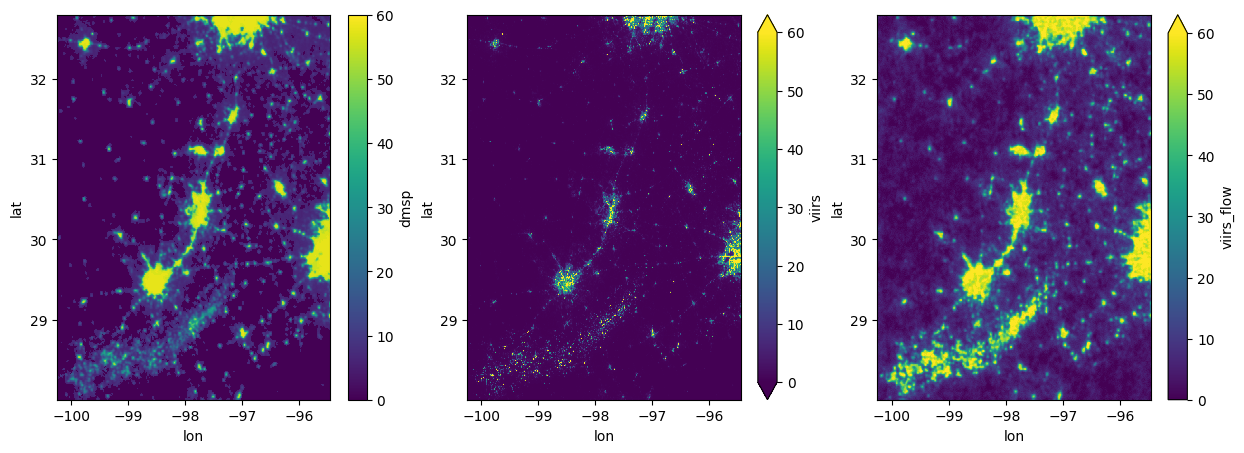

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_flow.plot(ax=ax[2], vmax=60)

# FlowMatchEulerDiscreteScheduler

In [19]:
import wandb
wandb.login(key="70f85253c59220a4439123cc3c97280ece560bf5")  # Replace with your API key
n_epochs =5000

wandb.init(project="diffusion_test", name="FlowMatchEulerDiscreteScheduler", config={
    "epochs": n_epochs,
    "batch_size": train_dataloader.batch_size,
    "learning_rate": 1e-4,
    "weight_decay": 1e-2,
    "scheduler": "CosineAnnealingLR"
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: manmeet3591 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from diffusers import UNet2DModel, FlowMatchEulerDiscreteScheduler
import wandb

# Initialize FlowMatchEulerDiscreteScheduler
noise_scheduler = FlowMatchEulerDiscreteScheduler()

In [21]:
def compute_density_for_timestep_sampling(
    weighting_scheme = 'logit_normal',
    batch_size = 20,
    logit_mean=0.0,
    logit_std = 1.0,
    mode_scale = 1.29,
    device =  "cuda",
    generator = None,
):
    """
    Compute the density for sampling the timesteps when doing SD3 training.

    Courtesy: This was contributed by Rafie Walker in https://github.com/huggingface/diffusers/pull/8528.

    SD3 paper reference: https://arxiv.org/abs/2403.03206v1.
    """
    if weighting_scheme == "logit_normal":
        u = torch.normal(mean=logit_mean, std=logit_std, size=(batch_size,), device=device, generator=generator)
        u = torch.nn.functional.sigmoid(u)
    return u

In [22]:
def get_sigmas(timesteps, n_dim=4, dtype=torch.float32):
    sigmas = noise_scheduler.sigmas.to(device='cuda', dtype=dtype)
    schedule_timesteps = noise_scheduler.timesteps.to('cuda')
    timesteps = timesteps.to('cuda')
    step_indices = [(schedule_timesteps == t).nonzero().item() for t in timesteps]

    sigma = sigmas[step_indices].flatten()
    while len(sigma.shape) < n_dim:
        sigma = sigma.unsqueeze(-1)
    return sigma

In [23]:
# Define Optimizer and Loss
opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
loss_fn = nn.MSELoss()

# Learning rate scheduler
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5000, eta_min=1e-6)

# Early Stopping Parameters
n_epochs = 5000
early_stopping_patience = 1000
best_val_loss = float("inf")
patience_counter = 0
print_step = 1

# Training Loop
for epoch in range(n_epochs):
    model.train()
    losses = []

    for batch in train_dataloader:
        input, targets = batch
        x_1 = targets.to(device)  # Original target images (grayscale, 1 channel)
        x_0 = torch.randn_like(x_1)  # Gaussian noise
        t = torch.rand(x_1.shape[0], 1, 1, 1, device=device)  # Continuous time steps

        bsz = input.shape[0]
        u = compute_density_for_timestep_sampling(batch_size=bsz)
        indices = (u * noise_scheduler.config.num_train_timesteps).long()
        timesteps = noise_scheduler.timesteps.to(device=device)[indices]
        sigmas = get_sigmas(timesteps, n_dim=x_1.ndim, dtype=x_1.dtype)
        x_t = (1.0 - sigmas) * x_0 + sigmas * x_1


        # Compute interpolated samples and velocity field
        #x_t = (1 - t) * x_0 + t * x_1
        # x_t = noise_scheduler.add_noise(x_1, x_0, t.flatten())
        dx_t = x_1 - x_0  # Ground truth velocity

        # Fake class conditioning (replace with real labels if available)
        #class_labels = torch.rand(x_1.shape[0], 1, x_1.shape[2], x_1.shape[3], device=device)
        class_labels = input.to(device)

        # Concatenate class conditioning to the input
        model_input = torch.cat((x_t, class_labels), dim=1)  # (batch, 2, 32, 32)

        # Forward pass
        pred_dx_t = model(model_input, timestep=t.flatten()).sample  # UNet output

        # Compute Loss
        loss = loss_fn(pred_dx_t, dx_t)

        # Backward pass
        opt.zero_grad()
        loss.backward()
        opt.step()
        lr_scheduler.step()

        losses.append(loss.item())

    avg_train_loss = sum(losses) / len(losses)

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input, targets = batch
            x_1 = targets.to(device)
            x_0 = torch.randn_like(x_1)
            t = torch.rand(x_1.shape[0], 1, 1, 1, device=device)
            bsz = input.shape[0]
            u = compute_density_for_timestep_sampling(batch_size=bsz)
            indices = (u * noise_scheduler.config.num_train_timesteps).long()
            timesteps = noise_scheduler.timesteps.to(device=device)[indices]
            sigmas = get_sigmas(timesteps, n_dim=x_1.ndim, dtype=x_1.dtype)
            x_t = (1.0 - sigmas) * x_0 + sigmas * x_1


#            x_t = (1 - t) * x_0 + t * x_1
#            x_t = noise_scheduler.add_noise(x_1, x_0, t.flatten())
            dx_t = x_1 - x_0

            #class_labels = torch.rand(x_1.shape[0], 1, x_1.shape[2], x_1.shape[3], device=device)
            class_labels = input.to(device)
            model_input = torch.cat((x_t, class_labels), dim=1)

            pred_dx_t = model(model_input, timestep=t.flatten()).sample
            loss = loss_fn(pred_dx_t, dx_t)
            val_losses.append(loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    # Log results to Weights & Biases
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": lr_scheduler.get_last_lr()[0]
    })

    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_flow_matching_unet.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        print(f"Early stopping patience: {patience_counter}/{early_stopping_patience}")

    # Early stopping
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered! Training stopped.")
        break

Epoch 0: Train Loss = 0.453161, Val Loss = 0.178224
Saved best model!
Epoch 1: Train Loss = 0.151074, Val Loss = 0.137248
Saved best model!
Epoch 2: Train Loss = 0.119130, Val Loss = 0.127975
Saved best model!
Epoch 3: Train Loss = 0.112552, Val Loss = 0.109444
Saved best model!
Epoch 4: Train Loss = 0.094262, Val Loss = 0.104966
Saved best model!
Epoch 5: Train Loss = 0.089731, Val Loss = 0.090895
Saved best model!
Epoch 6: Train Loss = 0.080939, Val Loss = 0.084403
Saved best model!
Epoch 7: Train Loss = 0.074293, Val Loss = 0.079671
Saved best model!
Epoch 8: Train Loss = 0.068147, Val Loss = 0.070620
Saved best model!
Epoch 9: Train Loss = 0.063664, Val Loss = 0.063165
Saved best model!
Epoch 10: Train Loss = 0.057610, Val Loss = 0.065305
Early stopping patience: 1/1000
Epoch 11: Train Loss = 0.057386, Val Loss = 0.069826
Early stopping patience: 2/1000
Epoch 12: Train Loss = 0.059295, Val Loss = 0.059860
Saved best model!
Epoch 13: Train Loss = 0.054779, Val Loss = 0.067062
Early 

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load trained model
model.load_state_dict(torch.load("best_flow_matching_unet.pth"))
model.eval()



x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)

# Flow Matching Inference
pred_patches = []
n_steps = 50  # Number of steps for gradual transformation
time_steps = torch.linspace(0, 1.0, n_steps + 1).to(device)

for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    x_0 = torch.randn_like(batch).to(device)  # Start with random noise
    x_t = x_0.clone()  # Initialize with noise
    class_labels = batch  # Conditioning input

    for i in tqdm(range(n_steps), desc="Inference Steps"):
        t_start = time_steps[i].expand(batch.shape[0], 1, 1, 1)  # Expand for batch
        t_end = time_steps[i + 1].expand(batch.shape[0], 1, 1, 1)

        model_input = torch.cat((x_t, class_labels), dim=1)  # Concatenate conditioning
        with torch.no_grad():
            pred_dx_t = model(model_input, timestep=t_start.flatten()).sample  # Predict velocity

        # Apply Flow Matching step
        x_t = x_t + (t_end - t_start) * pred_dx_t

    pred_patches.append(x_t.cpu().numpy())

# Reconstruct final high-resolution image
predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

<ipython-input-24-7d552d9a8176>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_flow_matching_unet.pth"))
Inference Steps: 100%|█████

In [25]:
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)
reconstructed_predicted_sr.shape

(576, 576)

In [26]:
lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]

In [27]:
import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_flow': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

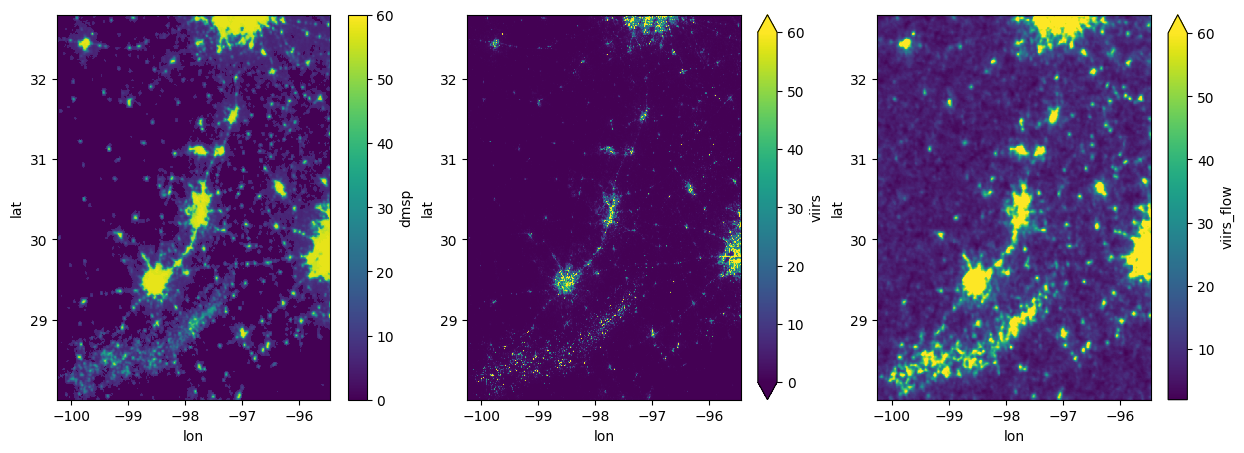

In [28]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_flow.plot(ax=ax[2], vmax=60)

# Sampling steps = 1

<ipython-input-31-529ac9313910>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_flow_matching_unet.pth"))
Inference Steps: 100%|█████

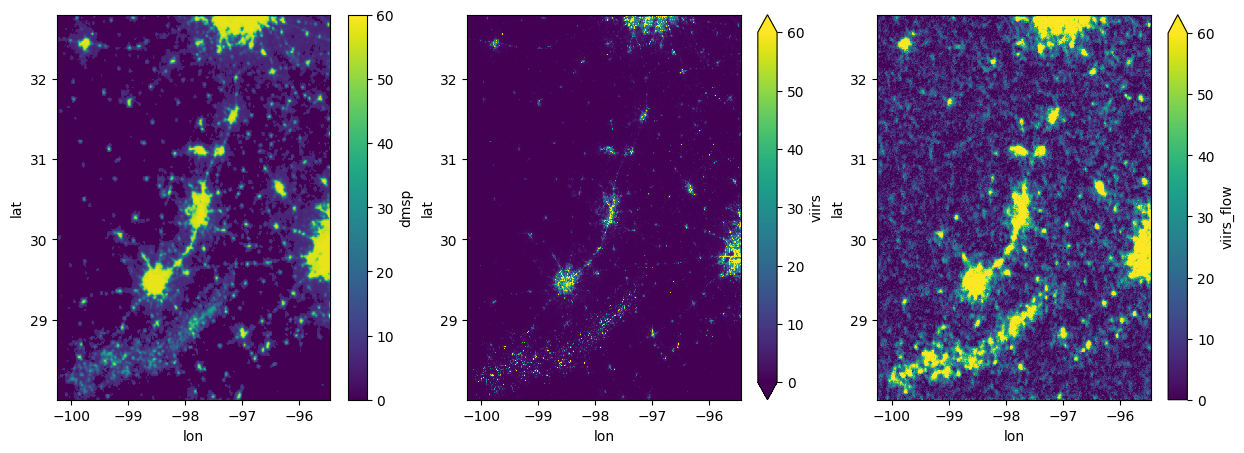

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load trained model
model.load_state_dict(torch.load("best_flow_matching_unet.pth"))
model.eval()



x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)

# Flow Matching Inference
pred_patches = []
n_steps = 1  # Number of steps for gradual transformation
time_steps = torch.linspace(0, 1.0, n_steps + 1).to(device)

for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    x_0 = torch.randn_like(batch).to(device)  # Start with random noise
    x_t = x_0.clone()  # Initialize with noise
    class_labels = batch  # Conditioning input

    for i in tqdm(range(n_steps), desc="Inference Steps"):
        t_start = time_steps[i].expand(batch.shape[0], 1, 1, 1)  # Expand for batch
        t_end = time_steps[i + 1].expand(batch.shape[0], 1, 1, 1)

        model_input = torch.cat((x_t, class_labels), dim=1)  # Concatenate conditioning
        with torch.no_grad():
            pred_dx_t = model(model_input, timestep=t_start.flatten()).sample  # Predict velocity

        # Apply Flow Matching step
        x_t = x_t + (t_end - t_start) * pred_dx_t

    pred_patches.append(x_t.cpu().numpy())

# Reconstruct final high-resolution image
predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)

lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]


import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_flow': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_flow.plot(ax=ax[2], vmax=60)

# Sampling Steps = 100

<ipython-input-32-c7f7943b8a7d>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_flow_matching_unet.pth"))
Inference Steps: 100%|█████

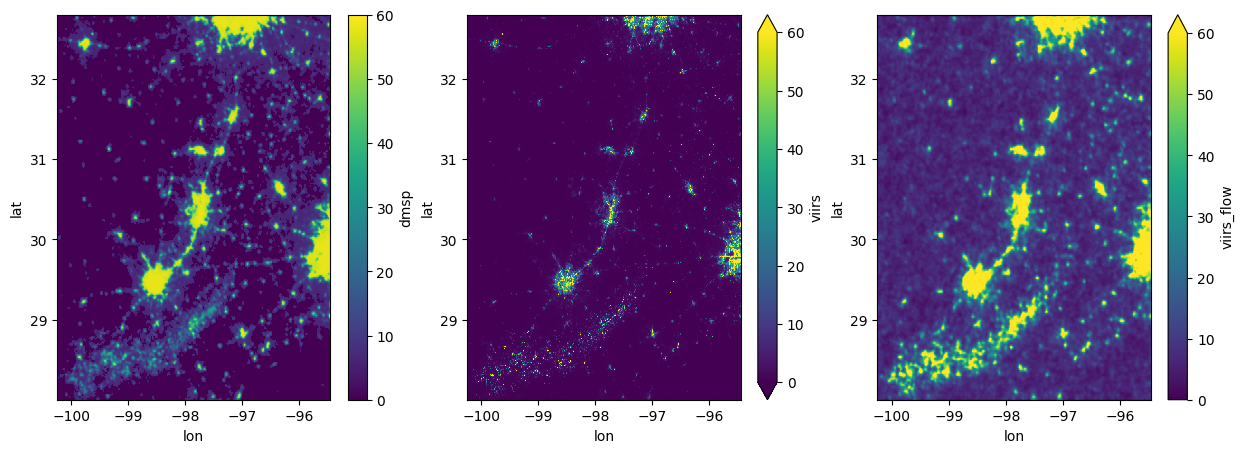

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load trained model
model.load_state_dict(torch.load("best_flow_matching_unet.pth"))
model.eval()



x_train = ds_viirs.values.astype(np.float32)
y_train = ds_dmsp.values[0,:,:].astype(np.float32)
img = x_train[:576,:576]

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_tensor = torch.from_numpy(x_train[:576, :576]).to(device).unsqueeze(0).unsqueeze(0)

# Flow Matching Inference
pred_patches = []
n_steps = 100  # Number of steps for gradual transformation
time_steps = torch.linspace(0, 1.0, n_steps + 1).to(device)

for batch in x_train_tensor:
    batch = batch.unsqueeze(0)  # Add batch dimension
    x_0 = torch.randn_like(batch).to(device)  # Start with random noise
    x_t = x_0.clone()  # Initialize with noise
    class_labels = batch  # Conditioning input

    for i in tqdm(range(n_steps), desc="Inference Steps"):
        t_start = time_steps[i].expand(batch.shape[0], 1, 1, 1)  # Expand for batch
        t_end = time_steps[i + 1].expand(batch.shape[0], 1, 1, 1)

        model_input = torch.cat((x_t, class_labels), dim=1)  # Concatenate conditioning
        with torch.no_grad():
            pred_dx_t = model(model_input, timestep=t_start.flatten()).sample  # Predict velocity

        # Apply Flow Matching step
        x_t = x_t + (t_end - t_start) * pred_dx_t

    pred_patches.append(x_t.cpu().numpy())

# Reconstruct final high-resolution image
predicted_sr_np = np.concatenate(pred_patches, axis=0) * y_train_max
predicted_sr_np[predicted_sr_np < 0] = 0.0  # Ensure non-negative values

reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)

lats = ds_dmsp.y.values[:576]
lons = ds_dmsp.x.values[:576]
dmsp_ = ds_dmsp.values[0,:576,:576]


import xarray as xr
ds_dmsp_ = xr.Dataset({
    'dmsp': xr.DataArray(
                data   = dmsp_,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},

                ),
    'viirs_flow': xr.DataArray(
                data   = reconstructed_predicted_sr,   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                ),
    'viirs': xr.DataArray(
                data   = ds_viirs.values[:576,:576],   # enter data here
                dims   = ['lat', 'lon'],
                coords = {'lat': lats, 'lon': lons},
                )
            },
    )

import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_dmsp_.dmsp.plot(ax=ax[0], vmax=60)
ds_dmsp_.viirs.plot(ax=ax[1], vmin=0, vmax=60)
ds_dmsp_.viirs_flow.plot(ax=ax[2], vmax=60)

In [33]:
!pwd

/content
